In [1]:
# House Price Prediction - Complete Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')



## 1. DATA LOADING AND EXPLORATION

In [2]:
print("=" * 70)
print("HOUSE PRICE PREDICTION - COMPLETE ANALYSIS")
print("=" * 70)
# Load data
df = pd.read_csv("Housing.csv")
print("\n1. DATASET OVERVIEW")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nDataset Info:\n{df.info()}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nBasic Statistics:\n{df.describe()}")


HOUSE PRICE PREDICTION - COMPLETE ANALYSIS

1. DATASET OVERVIEW
Dataset shape: (545, 13)

First few rows:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furni

## 2. EXPLORATORY DATA ANALYSIS

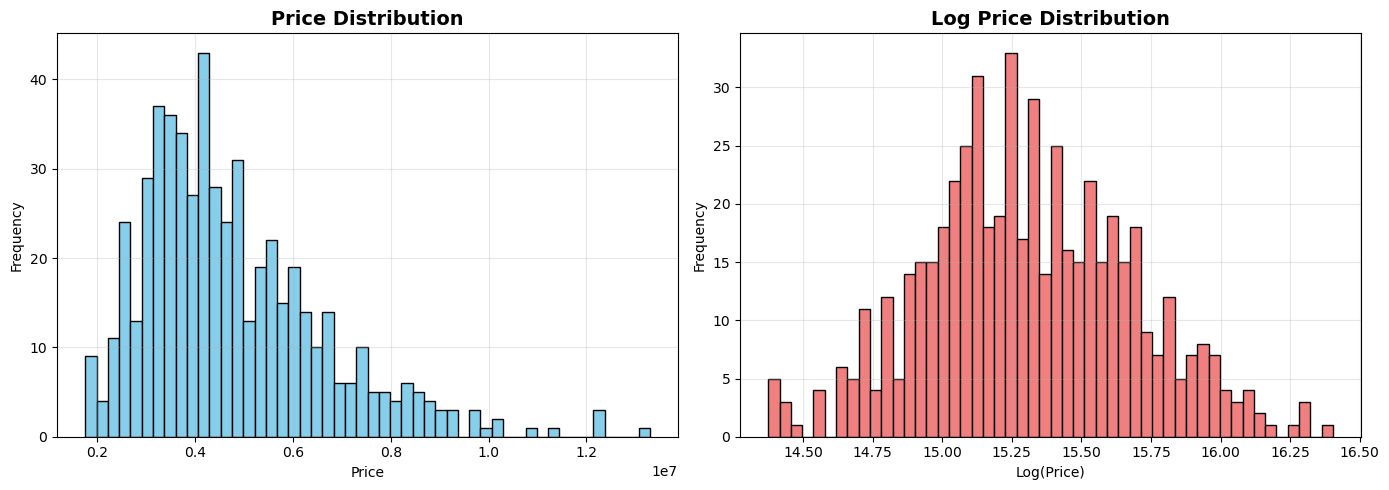

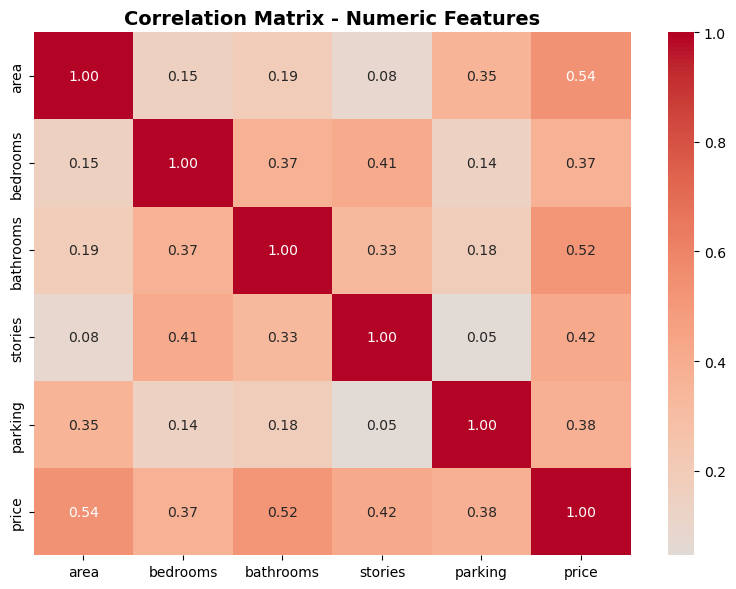

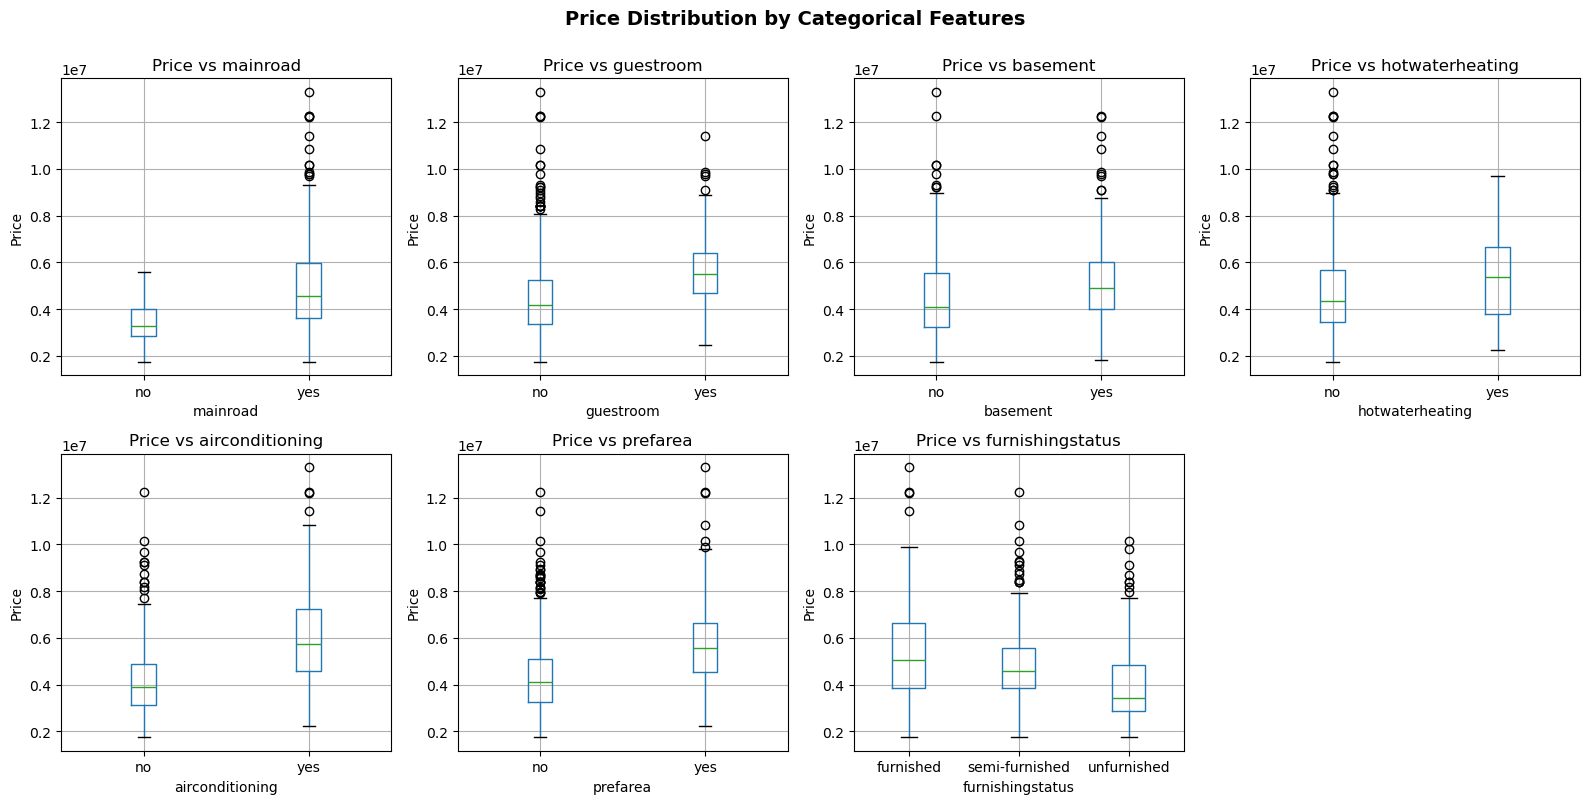

In [3]:
# Price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['price'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Log distribution for better visualization
axes[1].hist(np.log1p(df['price']), bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Log Price Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Numeric features correlation
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
correlation_matrix = df[numeric_features + ['price']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix - Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Categorical features analysis
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                        'airconditioning', 'prefarea', 'furnishingstatus']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    df.boxplot(column='price', by=feature, ax=axes[idx])
    axes[idx].set_title(f'Price vs {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Price')

axes[-1].axis('off')
plt.suptitle('Price Distribution by Categorical Features', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 3. DATA PREPROCESSING

In [4]:
# Define features
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                        'airconditioning', 'prefarea', 'furnishingstatus']
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Create preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])

print("Preprocessing pipeline created successfully!")

# Prepare X and Y
X = df.drop(['price'], axis=1)
Y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape: {Y.shape}")

Preprocessing pipeline created successfully!
Features shape: (545, 12)
Target shape: (545,)


## 4. TRAIN-TEST SPLIT

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, random_state=497, test_size=0.2
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train-Test Ratio: {len(X_train)/len(X_test):.2f}:1")

Training set size: 436
Test set size: 109
Train-Test Ratio: 4.00:1


## 5. MODEL TRAINING AND COMPARISON

In [6]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=497, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=497)
}

results = {}

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train model
    pipeline.fit(X_train, Y_train)
    
    # Make predictions
    Y_pred_train = pipeline.predict(X_train)
    Y_pred_test = pipeline.predict(X_test)
    
    # Calculate metrics
    r2_train = r2_score(Y_train, Y_pred_train)
    r2_test = r2_score(Y_test, Y_pred_test)
    mae_test = mean_absolute_error(Y_test, Y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, 
                                scoring='r2')
    
    results[model_name] = {
        'pipeline': pipeline,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mae': mae_test,
        'rmse': rmse_test,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': Y_pred_test
    }
    
    print(f"R² Score (Train): {r2_train:.4f}")
    print(f"R² Score (Test): {r2_test:.4f}")
    print(f"MAE: ${mae_test:,.2f}")
    print(f"RMSE: ${rmse_test:,.2f}")
    print(f"Cross-Validation R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



--- Linear Regression ---
R² Score (Train): 0.6505
R² Score (Test): 0.8053
MAE: $647,946.07
RMSE: $811,114.86
Cross-Validation R² (mean ± std): 0.6217 ± 0.0563

--- Random Forest ---
R² Score (Train): 0.9450
R² Score (Test): 0.6870
MAE: $744,222.56
RMSE: $1,028,405.48
Cross-Validation R² (mean ± std): 0.5887 ± 0.0944

--- Gradient Boosting ---
R² Score (Train): 0.8607
R² Score (Test): 0.6660
MAE: $760,400.55
RMSE: $1,062,355.88
Cross-Validation R² (mean ± std): 0.6112 ± 0.0810


## 6. MODEL COMPARISON AND VISUALIZATION


            Model  R² Train  R² Test           MAE         RMSE  CV Mean
Linear Regression  0.650488 0.805290 647946.073394 8.111149e+05 0.621735
    Random Forest  0.945042 0.686994 744222.557798 1.028405e+06 0.588741
Gradient Boosting  0.860680 0.665986 760400.547880 1.062356e+06 0.611160

✓ BEST MODEL: Linear Regression


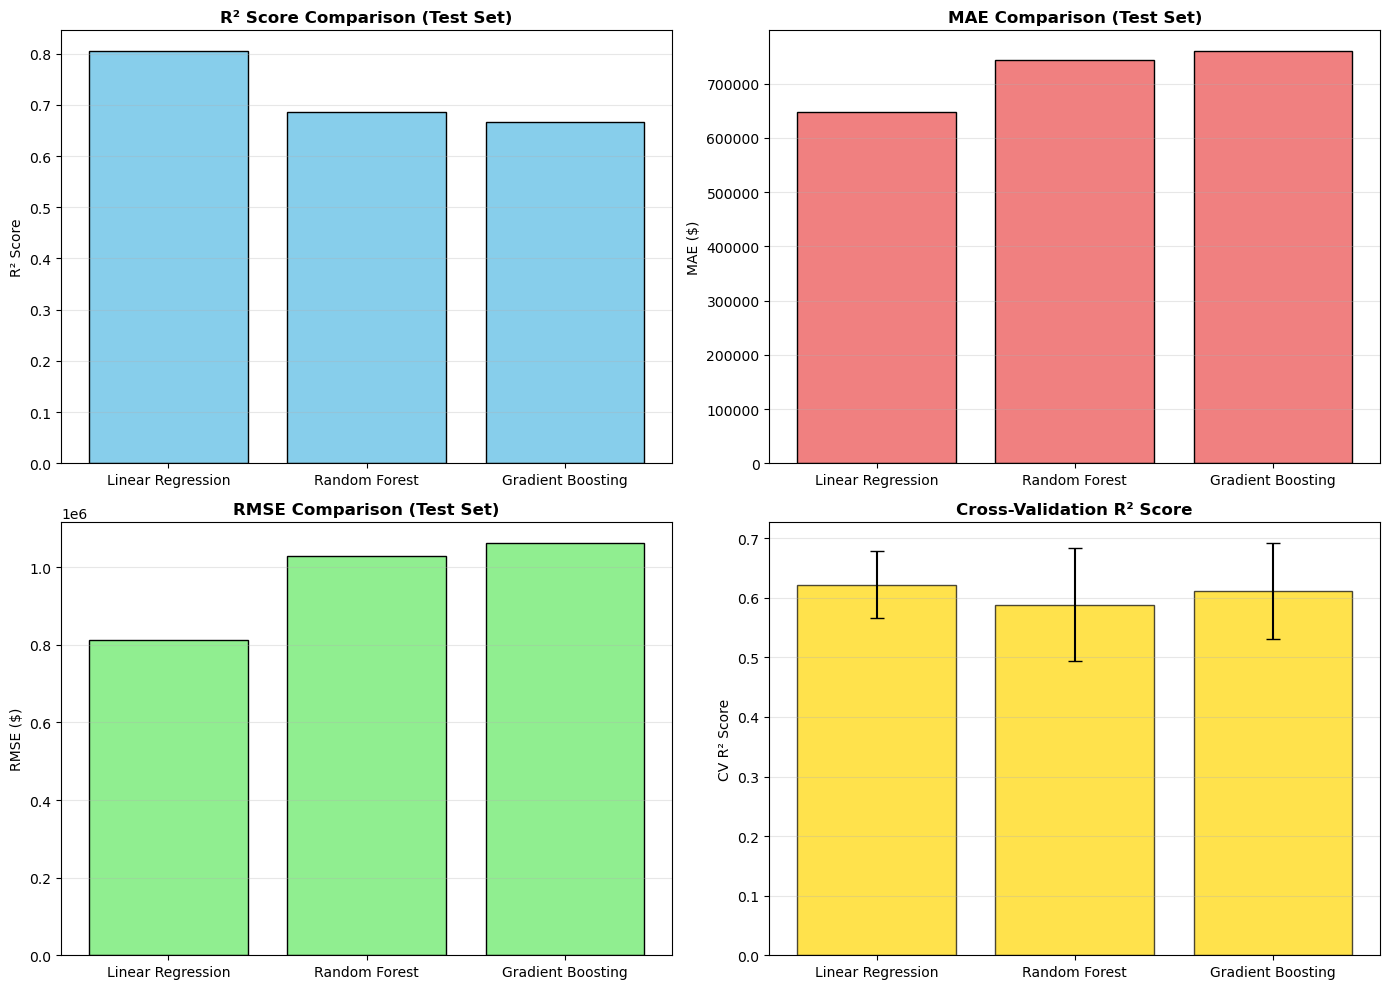

In [7]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'R² Train': [results[m]['r2_train'] for m in results.keys()],
    'R² Test': [results[m]['r2_test'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()],
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()]
})

print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model_name = max(results, key=lambda x: results[x]['r2_test'])
best_pipeline = results[best_model_name]['pipeline']
best_y_pred = results[best_model_name]['y_pred']

print(f"\n✓ BEST MODEL: {best_model_name}")

# Visualization - Model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² Test scores
axes[0, 0].bar(results.keys(), [results[m]['r2_test'] for m in results.keys()], 
               color='skyblue', edgecolor='black')
axes[0, 0].set_title('R² Score Comparison (Test Set)', fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# MAE comparison
axes[0, 1].bar(results.keys(), [results[m]['mae'] for m in results.keys()], 
               color='lightcoral', edgecolor='black')
axes[0, 1].set_title('MAE Comparison (Test Set)', fontweight='bold')
axes[0, 1].set_ylabel('MAE ($)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# RMSE comparison
axes[1, 0].bar(results.keys(), [results[m]['rmse'] for m in results.keys()], 
               color='lightgreen', edgecolor='black')
axes[1, 0].set_title('RMSE Comparison (Test Set)', fontweight='bold')
axes[1, 0].set_ylabel('RMSE ($)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Cross-validation comparison
cv_means = [results[m]['cv_mean'] for m in results.keys()]
cv_stds = [results[m]['cv_std'] for m in results.keys()]
axes[1, 1].bar(results.keys(), cv_means, yerr=cv_stds, capsize=5, 
               color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Cross-Validation R² Score', fontweight='bold')
axes[1, 1].set_ylabel('CV R² Score')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 7. BEST MODEL PREDICTIONS VISUALIZATION

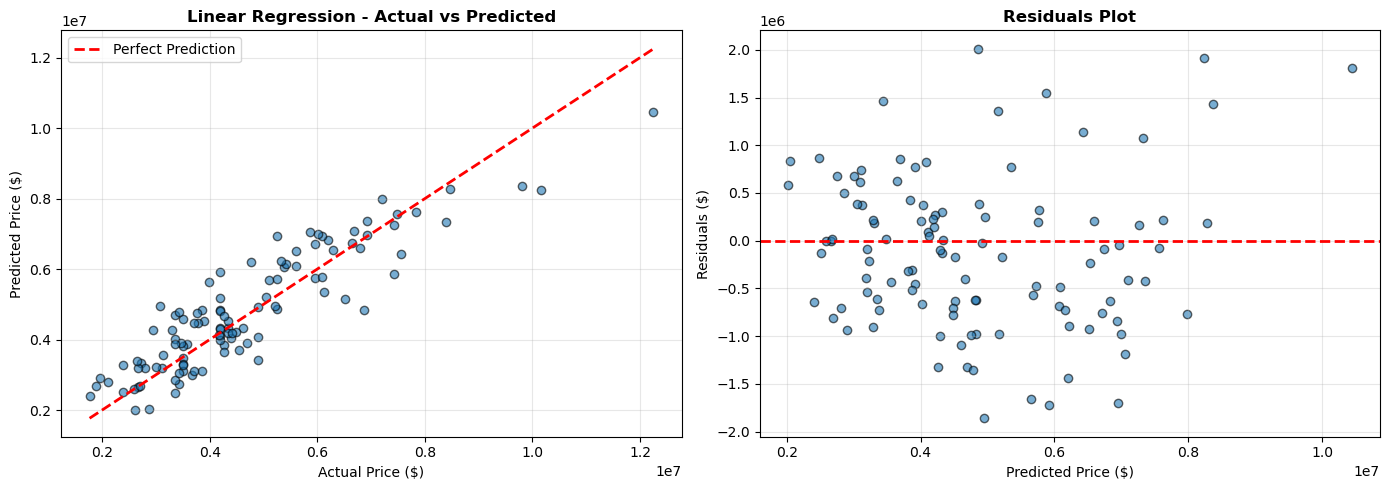

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(Y_test, best_y_pred, alpha=0.6, edgecolors='k')
axes[0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'{best_model_name} - Actual vs Predicted', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = Y_test - best_y_pred
axes[1].scatter(best_y_pred, residuals, alpha=0.6, edgecolors='k')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residuals Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 8. SAVE BEST MODEL

In [9]:
model_filename = 'best_house_prediction_model.pkl'
pickle.dump(best_pipeline, open(model_filename, 'wb'))
print(f"✓ Model saved as '{model_filename}'")



✓ Model saved as 'best_house_prediction_model.pkl'


## 9. TEST PREDICTION ON NEW DATA

In [10]:
# Load saved model
loaded_pipeline = pickle.load(open(model_filename, 'rb'))

# Sample input
input_data = pd.DataFrame({
    'area': [7420],
    'bedrooms': [4],
    'bathrooms': [2],
    'stories': [3],
    'mainroad': ['yes'],
    'guestroom': ['no'],
    'basement': ['no'],
    'hotwaterheating': ['no'],
    'airconditioning': ['yes'],
    'parking': [2],
    'prefarea': ['yes'],
    'furnishingstatus': ['furnished']
})

predicted_price = loaded_pipeline.predict(input_data)[0]
print(f"\nInput Features:")
print(input_data.to_string(index=False))
print(f"\n✓ Predicted House Price: ${predicted_price:,.2f}")




Input Features:
 area  bedrooms  bathrooms  stories mainroad guestroom basement hotwaterheating airconditioning  parking prefarea furnishingstatus
 7420         4          2        3      yes        no       no              no             yes        2      yes        furnished

✓ Predicted House Price: $8,085,504.00


## 10. SUMMARY

In [11]:
print(f"""
Best Model: {best_model_name}
- Training R² Score: {results[best_model_name]['r2_train']:.4f}
- Testing R² Score: {results[best_model_name]['r2_test']:.4f}
- Mean Absolute Error: ${results[best_model_name]['mae']:,.2f}
- Root Mean Squared Error: ${results[best_model_name]['rmse']:,.2f}
- Cross-Validation R²: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}

Model Interpretation:
- The model explains {results[best_model_name]['r2_test']*100:.2f}% of the variance in house prices
- On average, predictions are off by ${results[best_model_name]['mae']:,.2f}
""")

print("=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)


Best Model: Linear Regression
- Training R² Score: 0.6505
- Testing R² Score: 0.8053
- Mean Absolute Error: $647,946.07
- Root Mean Squared Error: $811,114.86
- Cross-Validation R²: 0.6217 ± 0.0563

Model Interpretation:
- The model explains 80.53% of the variance in house prices
- On average, predictions are off by $647,946.07

ANALYSIS COMPLETE!
